In [1]:
!git clone https://github.com/MorningStarTM/unsupervised-pre-training-vgg.git

Cloning into 'unsupervised-pre-training-vgg'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 147 (delta 74), reused 126 (delta 60), pack-reused 0
Receiving objects: 100% (147/147), 365.94 KiB | 7.17 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
%cd /kaggle/working/unsupervised-pre-training-vgg

/kaggle/working/unsupervised-pre-training-vgg


In [3]:
!ls

LICENSE  README.md  notebooks  tensorflow_src  torch_modules


In [11]:
BATCH_SIZE = 64
EPOCHS = 10
H,W,C = 256,256,3
lr = 1e-5
latent_dim = 512

In [17]:
from tensorflow_src import Autoencoder
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals
from glob import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from IPython import display
import matplotlib.gridspec as gridspec
from tensorflow_src.evaluation import load_ae

In [5]:
model = Autoencoder((256,256,3))
ae = model.build_autoencoder()
ae.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 8, 8, 256)      │     7,855,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 256, 256, 3)    │    10,214,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,069,795 (68.93 MB)

 Trainable params: 18,069,795 (68.93 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

ae.compile(optimizer=Adam(1e-5), loss=ssim_loss)

In [10]:
checkpoint_filepath = '/kaggle/working/ae_model_256.keras'
cbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
]

In [12]:
datagen = ImageDataGenerator(rescale=1./255)

train_batches = datagen.flow_from_directory(
    '/kaggle/input/multi-cancer/Multi Cancer/Brain Cancer',
    target_size=(H,W),
    batch_size=BATCH_SIZE,
    class_mode='input',  # Use 'input' mode for autoencoder training
    shuffle=True
)

Found 15000 images belonging to 3 classes.


In [14]:
test_batches = datagen.flow_from_directory(
    '/kaggle/input/labeled-mri-brain-tumor-dataset/Brain Tumor labeled dataset',
    target_size=(H,W),
    batch_size=BATCH_SIZE,
    class_mode='input',  # Use 'input' mode for autoencoder training
    shuffle=True
)

Found 2175 images belonging to 4 classes.


In [22]:
history = ae.fit(train_batches, steps_per_epoch=15000  // BATCH_SIZE, epochs=25, callbacks=cbacks, validation_data=test_batches)

Epoch 1/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.2158
Epoch 1: val_loss improved from 0.28544 to 0.28405, saving model to /kaggle/working/ae_model_256.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 131s 551ms/step - loss: 0.2158 - val_loss: 0.2841
Epoch 2/25
  1/234 ━━━━━━━━━━━━━━━━━━━━ 1:55 497ms/step - loss: 0.2082

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.28405 to 0.28380, saving model to /kaggle/working/ae_model_256.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.2082 - val_loss: 0.2838
Epoch 3/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.2159
Epoch 3: val_loss improved from 0.28380 to 0.28292, saving model to /kaggle/working/ae_model_256.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 129s 544ms/step - loss: 0.2159 - val_loss: 0.2829
Epoch 4/25
  1/234 ━━━━━━━━━━━━━━━━━━━━ 1:55 495ms/step - loss: 0.2081
Epoch 4: val_loss improved from 0.28292 to 0.28289, saving model to /kaggle/working/ae_model_256.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.2081 - val_loss: 0.2829
Epoch 5/25
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - loss: 0.2130
Epoch 5: val_loss improved from 0.28289 to 0.28193, saving model to /kaggle/working/ae_model_256.keras
234/234 ━━━━━━━━━━━━━━━━━━━━ 130s 546ms/step - loss: 0.2131 - val_loss: 0.2819
Epoch 6/25
  1/234 ━━━━━━━━━━━━━━━━━━━━ 1:55 495ms/step - loss: 0.

In [23]:
saved_model = load_ae("/kaggle/working/ae_model_256.keras", ssim_loss)

In [24]:
batch_images, _ = next(test_batches)
predictions = saved_model.predict(batch_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


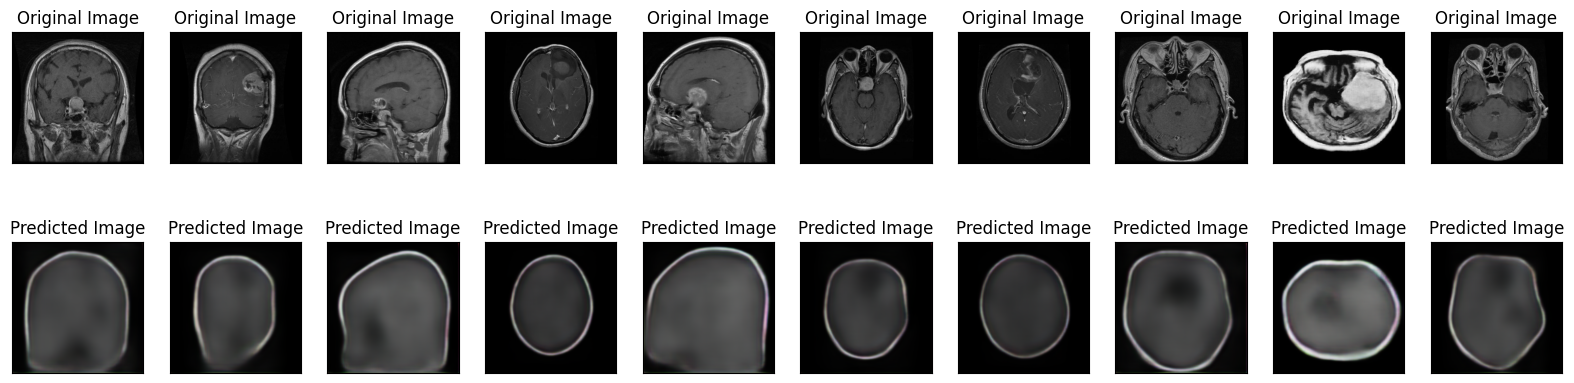

In [25]:
n = 10
plt.figure(figsize=(20,5))
for i in range(n):
    
    ax = plt.subplot(2, n, i+1)
    ax.set_title("Original Image")
    plt.imshow(batch_images[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n, i+1+n)
    ax.set_title("Predicted Image")
    plt.imshow(predictions[i].reshape(256,256,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)